In [1]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.applications import MobileNetV3Large
# from tensorflow.keras.applications import EfficientNetV2B1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
# Konfigurasi penggunaan memori GPU agar lebih efisien
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [3]:
# def _bytes_feature(value):
#     """Returns a bytes_list from a string / byte."""
#     if isinstance(value, type(tf.constant(0))): 
#         value = value.numpy()  
#     return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# def _float_feature(value):
#     """Returns a float_list from a float / double."""
#     return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

# def _int64_feature(value):
#     """Returns an int64_list from a bool / enum / int / uint."""
#     return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# def serialize_example(image, label):
#     image = tf.cast(image * 255.0, tf.uint8)
#     feature = {
#         'image': _bytes_feature(tf.io.encode_jpeg(image).numpy()),
#         'label': _int64_feature(label),
#     }
#     example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
#     return example_proto.SerializeToString()

# def write_tfrecords(file_path, dataset, class_names):
#     with tf.io.TFRecordWriter(file_path) as writer:
#         for image_path in dataset:
#             image = tf.io.read_file(image_path)
#             image = tf.image.decode_jpeg(image, channels=3)
#             image = tf.image.resize(image, [256, 256])
#             image /= 255.0
#             label_name = tf.strings.split(image_path, os.path.sep)[-2]
#             label = tf.argmax(tf.cast(tf.equal(class_names, label_name), tf.float32))
#             tf_example = serialize_example(image, label)
#             writer.write(tf_example)

train_dir = 'New_Plant_Diseases_Dataset(Augmented)/train'
validation_dir = 'New_Plant_Diseases_Dataset(Augmented)/valid'
class_names = np.array(sorted([item for item in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, item))]))

# train_paths = tf.io.gfile.glob("{train_dir}/*/*")
# valid_paths = tf.io.gfile.glob("{validation_dir}/*/*")

# write_tfrecords('train256.tfrecord', train_paths, class_names)
# write_tfrecords('valid256.tfrecord', valid_paths, class_names)


In [4]:
def _parse_image_function(proto):
    keys_to_features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    image = tf.io.decode_jpeg(parsed_features['image'], channels=3)
    # image = tf.image.resize(image, [128, 128])
    image = tf.image.resize(image, [224, 224])
    image /= 255.0
    return image, parsed_features['label']

def load_dataset(file_path, batch_size):
    dataset = tf.data.TFRecordDataset(file_path)
    dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset


In [5]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label


In [6]:
# Parameters
batch_size = 16
# img_size = (128, 128)
img_size = (224, 224)

# Load dataset from TFRecords
train_ds = load_dataset('train256.tfrecord', batch_size)
# train_ds = train_ds.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = load_dataset('valid256.tfrecord', batch_size)

# Define and compile the model
# base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
# base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
# base_model = EfficientNetB3(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
# base_model = EfficientNetV2B1(input_shape=(128, 128, 3), include_top=False, weights='imagenet')


base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])
# model = Sequential([
#     base_model,
#     GlobalAveragePooling2D(),
#     Dropout(0.5),
#     Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     Dropout(0.5),
#     Dense(len(class_names), activation='softmax')
# ])
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
#     MaxPooling2D((2, 2)),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(len(class_names), activation='softmax')
# ])

model.compile(optimizer=Adam(learning_rate=0.000009),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 38)                48678     
                                                                 
Total params: 2,306,662
Trainable params: 48,678
Non-trainable params: 2,257,984
_________________________________________________________________


In [7]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
# history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stopping])
# history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stopping, reduce_lr])
# history = model.fit(train_ds, validation_data=val_ds, epochs=50)
history = model.fit(train_ds, validation_data=val_ds, epochs=300, callbacks=[reduce_lr])

Epoch 1/300
4394/4394 [==============================] - 100s 22ms/step - loss: 4.3168 - accuracy: 0.0501 - val_loss: 3.2685 - val_accuracy: 0.1181 - lr: 9.0000e-06
Epoch 2/300
4394/4394 [==============================] - 94s 21ms/step - loss: 3.0068 - accuracy: 0.2029 - val_loss: 2.7554 - val_accuracy: 0.2493 - lr: 9.0000e-06
Epoch 3/300
4394/4394 [==============================] - 94s 21ms/step - loss: 2.4386 - accuracy: 0.3283 - val_loss: 2.2744 - val_accuracy: 0.3635 - lr: 9.0000e-06
Epoch 4/300
4394/4394 [==============================] - 94s 21ms/step - loss: 2.0074 - accuracy: 0.4365 - val_loss: 1.9066 - val_accuracy: 0.4592 - lr: 9.0000e-06
Epoch 5/300
4394/4394 [==============================] - 94s 21ms/step - loss: 1.6981 - accuracy: 0.5188 - val_loss: 1.6311 - val_accuracy: 0.5353 - lr: 9.0000e-06
Epoch 6/300
4394/4394 [==============================] - 94s 21ms/step - loss: 1.4649 - accuracy: 0.5850 - val_loss: 1.4250 - val_accuracy: 0.5948 - lr: 9.0000e-06
Epoch 7/300
439

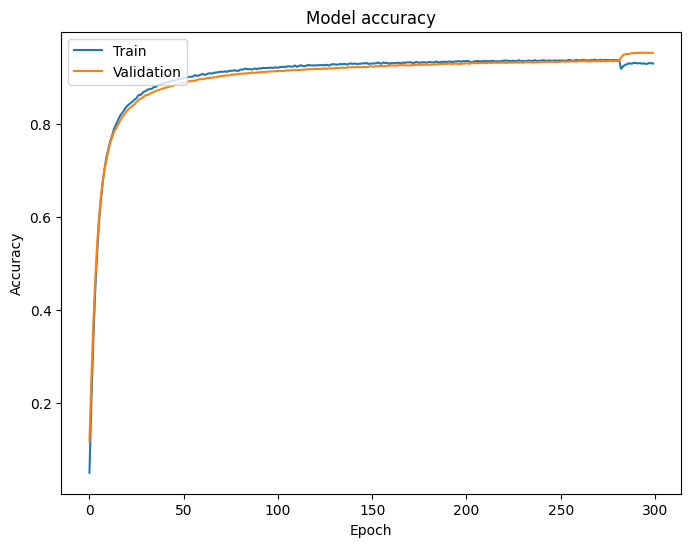

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [10]:
model.save('plant_disease_MobileNetV2(input256)(noaugment)(lr0.000009(reducelr)).h5')